In [1]:
import igraph as ig
import math
import random as rd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange, date2num
import numpy as np
import random
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 18,
        }
params = {'legend.fontsize': 16,
          'legend.handlelength': 2.}
plt.rcParams.update(params)

import seaborn as sns
import itertools
import csv
import matplotlib.ticker as mticker

class Labeloffset():
    def __init__(self,  ax, label="", axis="y"):
        self.axis = {"y":ax.yaxis, "x":ax.xaxis}[axis]
        self.label=label
        ax.callbacks.connect(axis+'lim_changed', self.update)
        ax.figure.canvas.draw()
        self.update(None)

    def update(self, lim):
        fmt = self.axis.get_major_formatter()
        self.axis.offsetText.set_visible(False)
        self.axis.set_label_text(self.label + " "+ fmt.get_offset() )


In [2]:
import pandas as pd

df = pd.read_excel ('Book2.xlsx') #place "r" before the path string to address special character, such as '\'. Don't forget to put the file name at the end of the path + '.xlsx'
# print (df)

In [3]:
def double_smoothlog(time, bound1 , bound2, rate1 , rate2 , midpoint1 , midpoint2):
    result = []
    mini = 0
    maxi = time
    for x in range(time):
        if (midpoint1 > maxi | midpoint2 > maxi | midpoint1 < mini | midpoint2 < mini | midpoint1 > midpoint2):
            stop('midpoints not in range!')
        t1 = 1 / (1 + math.exp(-rate1*(x - midpoint1)))
        t2 = 1 / (1 + math.exp( rate2*(x - midpoint2)))
        out = bound1 + (bound2-bound1) * ((t1 + t2) - 1)
        result.append(out)
    return(result)

In [4]:
def simfxn(Time,popul):
    bound1 = 0.028
    bound2 = 0.001
    rate1 = 0.09
    rate2 = 0.04
    midpoint1 = 50
    midpoint2 = 126
    beta = double_smoothlog(Time, bound1 , bound2, rate1 , rate2 , midpoint1 , midpoint2)
    g=ig.Graph.Erdos_Renyi(popul, m=5*popul)
    pop = g.vcount()
    g.vs["state"] = "S"
    g.vs["duration"] = 0
    #randomly select % of the population to be vaccinated
    perc_vac = int(0.1*pop)
    vac_eff = 0.4  # vaccine efficacy
    init_vac_grp = random.sample(list(range(pop)), perc_vac)
    g.vs[init_vac_grp]["state"] = "VS"
    #randomly select an infected node to start epidemic
    i = rd.randint(0, pop-1)
    if g.vs[i]["state"] != 'VS':   # if initial node is not vaccinated, then set it as exposed
        g.vs[i]["state"] = "A"
    
    nb_S = [pop-len(init_vac_grp)]
    S_initial = pop-len(init_vac_grp)
    nb_E = [1]
    nb_I = [0]
    nb_R = [0]
    nb_V = [0]#len(init_vac_grp)]
    exposed_susc = []       # susceptibles who are exposed
    exposed_vac = []         # vaccinated group exposed after 14 days
    exp_inf = []             # exposed who get serious infection after incubation period
    exp_recovered = []       # exposed who recover after incubation period
    ini_vac_exp_ft = []      # initial vaccinated group exposed in 14 days
    num_vac_after_ft = []        # number of unexposed initial vaccinated after 14 days
    Time = Time

    for time in range(Time): #no. of days 
        for mv in init_vac_grp:
            g.vs[mv]["duration"] += 1
            if g.vs[mv]["duration"] in range (15,Time):
                if g.vs[mv]["state"] == "VS":
                    g.vs[mv]["state"] = "V"
           
        for n in g.vs.select(state_eq = "A"): #iterates through each node in the network
            g.vs[n.index]["duration"] += 1 
            if g.vs[n.index]["duration"] in range (5,19):
                nr = np.random.binomial(1,0.2,1)
                if nr == 1:
                    g.vs[n.index]["state"] = "I"
                    exp_inf.append(n)
                else:
                    g.vs[n.index]["state"] = "R"
                    exp_recovered.append(n)

            for nb in g.neighbors(n): #iterates through neighbours of that node
                if g.vs[nb]["state"] == "S": #if node is infected...
                    s=np.random.binomial(1, beta[time],1)
                    if s == 1:
                        g.vs[nb]["state"] = "A" 
                        exposed_susc.append(nb)
                if g.vs[nb]["state"] == "VS" :
                    if g.vs[nb]["duration"] in range (1,14):
                        u = np.random.binomial(1, beta[time],1)
                        if u == 1:
                            g.vs[nb]["state"] = "A" 
                            ini_vac_exp_ft.append(nb)       #initial vaccinated group exposed in 14 days
                if g.vs[nb]["state"] == "V" :
                    if g.vs[nb]["duration"] :
                        ju = np.random.binomial(1, (1-vac_eff)*beta[time],1)
                        if ju == 1:
                            g.vs[nb]["state"] = "A" 
                            exposed_vac.append(nb)         # vaccinated group exposed after 14 days

        for m in g.vs.select(state_eq = "I"): #iterates through each node in the network
            g.vs[m.index]["duration"] += 1                                
            for nbm in g.neighbors(m): #iterates through neighbours of that node
                if g.vs[nbm]["state"] == "S": #if node is infected...
                    j=np.random.binomial(1, beta[time],1)
                    if j == 1:
                        g.vs[nbm]["state"] = "A"
                        exposed_susc.append(nbm)
            if g.vs[m.index]["duration"] in range(19,Time):
                g.vs[m.index]["state"] = 'R'

                
        nb_S.append(len(g.vs.select(state_eq = "S"))) #no. of susceptibles in population
        nb_E.append(len(g.vs.select(state_eq = "A"))) #no. of recovereds in population
        nb_I.append(len(g.vs.select(state_eq = "I"))) #no. of infecteds in population
        nb_R.append(len(g.vs.select(state_eq = "R"))) #no. of recovereds in population
        nb_V.append(len(g.vs.select(state_eq = "V"))) #no. of recovereds in population

        propo_exp_vac_ftdays = (len(ini_vac_exp_ft)/len(init_vac_grp))*100   # proportion of vaccinated that are exposed within 14 days    
        propo_exp_unvac = (len(exposed_susc)/(S_initial))*100  # proportion of unvaccinated (susceptible) that are exposed
        propo_exp_vac = (len(exposed_vac)/perc_vac)*100        # proportion of vaccinated that are exposed after 14 days
#         propo_exp_serious_inf = (len(exp_inf)/len(g.vs.select(state_eq = "A")))*100         # proportion of exposed that become serious infection
#         print(len(g.vs.select(state_eq = "A")))
    return(nb_S,nb_E,nb_I,nb_R,nb_V,len(exp_inf), len(exp_recovered), propo_exp_unvac,propo_exp_vac,propo_exp_vac_ftdays)#,count, fig)


In [5]:
Time = 359
popul = 10000
rep = 10
simout=simfxn(Time,popul)

In [6]:
datavector = []
for i in range(rep):          #repeat simulation 10 times
    simu = simfxn(Time,popul)
    datavector.append(simu)

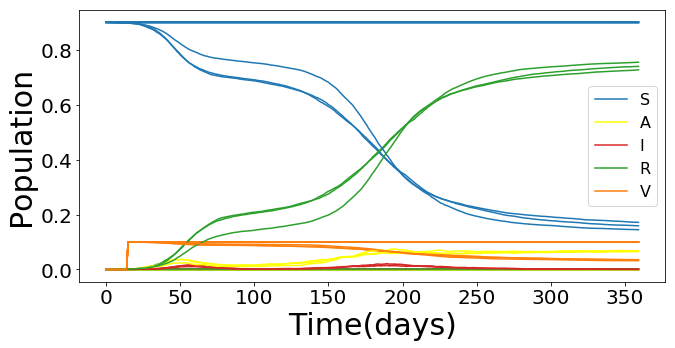

In [7]:
plt.figure(figsize=(10.5, 5))

plt.plot([x/popul for x in simout[0]], label='S',color = '#1f77b4')
plt.plot([x/popul for x in simout[1]], label='A',color = 'yellow')
plt.plot([x/popul for x in simout[2]], label='I',color = '#d62728')
plt.plot([x/popul for x in simout[3]], label='R',color = '#2ca02c')
plt.plot([x/popul for x in simout[4]], label='V',color = '#ff7f0e')
plt.legend(loc='right')

s_final = []
e_final = []
i_final = []
r_final = []
v_final = []

i_each = []

sList = []
eList = []
iList = []
rList = []
vList = []
i_max = []

prop_exp_vac_ft = []
prop_exp_vac = []
prop_exp_unvac = []

all_exp_inf = []
all_exp_recovered = []

perc_inf = []
for n in datavector:
    sList = [x / popul for x in n[0]]
    eList = [x / popul for x in n[1]]
    iList = [x / popul for x in n[2]]
    rList = [x / popul for x in n[3]]
    vList = [x / popul for x in n[4]]
 
    plt.plot(sList,color = '#1f77b4')
    plt.plot(eList,color = 'yellow')
    plt.plot(iList,color = '#d62728')
    plt.plot(rList,color = '#2ca02c')
    plt.plot(vList,color = '#ff7f0e')
    
    s_final.append(n[0][-1])
    e_final.append(n[1][-1])
    i_final.append(n[2][-1])
    r_final.append(n[3][-1])
    v_final.append(n[4][-1])
    
    prop_exp_vac_ft.append(n[-1])
    prop_exp_vac.append(n[-2])
    prop_exp_unvac.append(n[-3])
    
    all_exp_inf.append(n[-5])
    all_exp_recovered.append(n[-4])
    
    i_each.append(iList)
    i_max.append(max(iList))
    
# plt.axvspan(50, 126, color='gray', alpha=0.5, lw=0)
# plt.legend(loc='right')
plt.tick_params(axis = 'both', which = 'major', labelsize = 20)
plt.ylabel('Population', fontsize=30) 
plt.xlabel('Time(days)', fontsize=30)
x=list(range(Time))
plt.xticks(np.arange(min(x), max(x)+20, 50.0))
plt.show()

# plt.savefig('lookat3.pdf', bbox_inches='tight')